## Problem 4

In [1]:
import numpy as np
import hickle as hkl
import matplotlib.pyplot as plt
from jupyterthemes import jtplot

d = 30 #dimensions
u = np.zeros((d,1))
draws = 6
val = np.array([0,1,-1])

u_mat = np.zeros((d,draws))
for i in range(draws):
    for j in range(d):
        idx = np.random.uniform(0,1)
        if idx <2/3:
            idx = 0
        elif idx <5/6:
            idx = 1
        else:
            idx = 2
        u_mat[j,i]=val[idx]

#hkl.dump(u_mat,'u_mat.hkl')
u_mat = hkl.load('u_mat.hkl')

In [2]:
# Finding normalised correlation between draws
u1 = u_mat[:,0].reshape(d)
u2 = u_mat[:,1].reshape(d)

u1 = (u1 - np.mean(u1))/ np.std(u1)
u2 = (u2 - np.mean(u2))/ np.std(u2)

r = np.corrcoef(u1,u2,rowvar='True')
r


array([[ 1.        , -0.29172998],
       [-0.29172998,  1.        ]])

## Problem 5

In [3]:
# Component generation

def from_comp1(u_mat,sigma=0.01):
    res = np.zeros((d,1))
    v1 = np.random.randn()
    v2 = np.random.randn()

    
    cov = sigma**2 * np.ones((d,d))
    N = np.random.normal(0, cov)
    n_draw = np.random.randint(0,d) #index of noise vector to draw
    
    res = 2*u_mat[:,0] + 0.5*v1*u_mat[:,1] + v2*u_mat[:,2] + N[:,n_draw]
    return res


def from_comp2(u_mat,sigma=0.01):
    res = np.zeros((d,1))
    v1 = np.random.randn()
    v2 = np.random.randn()

    
    cov = sigma**2 * np.ones((d,d))
    N = np.random.normal(0, cov)
    n_draw = np.random.randint(0,d) #index of noise vector to draw
    
    res = 1.5*u_mat[:,3] + v1*u_mat[:,4] + 0.8*v2*u_mat[:,5] + N[:,n_draw]
    return res


def from_comp3(u_mat,sigma=0.01):
    res = np.zeros((d,1))
    v1 = np.random.randn()
    v2 = np.random.randn()

    
    cov = sigma**2 * np.ones((d,d))
    N = np.random.normal(0, cov)
    n_draw = np.random.randint(0,d) #index of noise vector to draw
    
    res = u_mat[:,5] + v1*(u_mat[:,0]-u_mat[:,1]) + 0.7*v2*u_mat[:,4] + N[:,n_draw]
    return res

In [4]:
sample_X = from_comp2(u_mat)
sample_X.shape

(30,)

## Problem 6

In [5]:
# Generating N data samples
N = 1000
multi_dim_data = np.zeros((d,N))  #x_i's
one_hot_labels = np.zeros((3,N))  #z_i's

for i in range(N):
    sample_pt = np.zeros((d,1))
    label = np.zeros((3,1))
    comp_draw = np.random.uniform(0,1)
    if comp_draw < 1/3:
        sample_pt = from_comp1(u_mat)
        label[0,0] = 1
    elif comp_draw < 2/3:
        sample_pt = from_comp2(u_mat)
        label[1,0] = 1
    else:
        sample_pt = from_comp3(u_mat)
        label[2,0] = 1
    multi_dim_data[:,i] = sample_pt.reshape(d)
    one_hot_labels[:,i] = label.reshape(3)

info = { 'data': multi_dim_data, 'label':one_hot_labels}
filenameP= 'data_'
filenameS = '_dim_' + str(d) + '.hkl'
#hkl.dump(info ,filenameP + str(N) + filenameS)  #uncomment to save new data

(1000, 3)
[345 328 327]


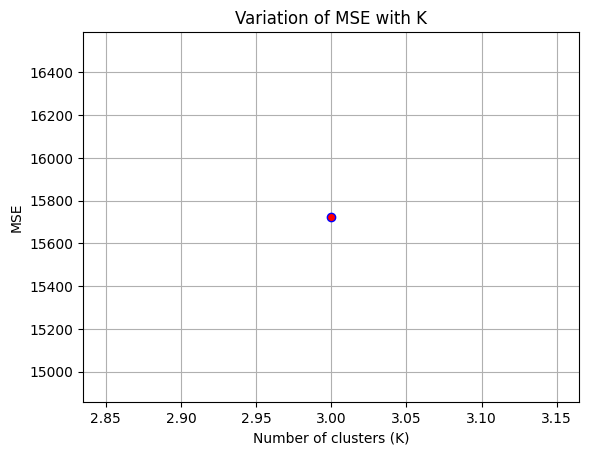

In [82]:
# KMeans CLustering
# Function to generate one-hot encoding of the KMeans Clustering algorithm
def oh_encode(prediction, n_cluster):
    one_hot_result = np.zeros((len(prediction),n_cluster))
    for i in range(len(prediction)):
        one_hot_result[i,prediction[i]]=1
    return one_hot_result



from sklearn.cluster import KMeans
from joblib import dump, load
import sys



info = hkl.load('data_1000_dim_30.hkl')    #change filename if req available: 200/400/1000
data = info['data'].T
true_labels = info['label'].T
K = np.array([3])  # different values of number of clusters K=2,3,4,5
mse  = np.zeros(len(K))

for i,k in enumerate(K,0):
    
    
    model_save_path = './saved_models/kmpp_dim_30_num_cluster_' + str(k) + '.joblib'
    smallest_MSE = sys.maxsize
    for iteration in  range(50):  #loop for selecting model with smallest MSE
        kmeans = KMeans(init = 'k-means++', n_init = 1, n_clusters=k).fit(data)
        if kmeans.inertia_ < smallest_MSE:
            smallest_MSE = kmeans.inertia_
            dump(kmeans,model_save_path)
    kmeans = load(model_save_path)
    #kmeans = KMeans(init = 'k-means++', n_init=1, n_clusters = k).fit(data)
    result  = kmeans.labels_
    mse[i] = kmeans.inertia_
    predicted_oh_label = oh_encode(kmeans.labels_, k) #matrix of a_i's
    print(predicted_oh_label.shape)


# Ground truth count for each category
truth = np.array([0, 0, 0])
cat1 = np.array([1, 0, 0])
cat2 = np.array([0, 1, 0])
cat3 = np.array([0, 0, 1])
for i in range(len(true_labels)):
    if np.array_equal(true_labels[i,:].reshape(3),cat1):
        truth[0] = truth[0] + 1
    elif np.array_equal(true_labels[i,:].reshape(3),cat2):
        truth[1] = truth[1] + 1
    else:
        truth[2] = truth[2] + 1


print(truth)


# Cluster point count for each category (may not compare one-to-one with ground truth)
#c1 = np.where(result==0)[0]
#c2 = np.where(result==1)[0]
#c3 = np.where(result==2)[0]
#print(len(c1),len(c2),len(c3))

# Plotting distortion vs k
plt.style.use('dark_background')
jtplot.reset()   #for resetting dark theme plot
plt.plot(K, mse,'-', marker='o', markerfacecolor = 'r', color ='b')
plt.xlabel('Number of clusters (K)')
plt.ylabel('MSE')
plt.title('Variation of MSE with K')
plt.grid()
plt.show()

In [83]:
predicted_oh_label.shape

(1000, 3)

In [9]:
# finding no.of components of each class for 3xK table
data = info['data'].T
true_labels = info['label'].T
cnt=0
for i in range(len(true_labels)):
    comp_arr = np.array([4])   # for the predicted cluster
    label_arr = np.array([[0],[0],[1]])  # for ground truth cluster
    if np.array_equal(kmeans.predict(data[i,:].reshape(1,d)),comp_arr) and np.array_equal(true_labels[i,:].reshape(3,1),label_arr):
        cnt = cnt + 1
        
cnt


0

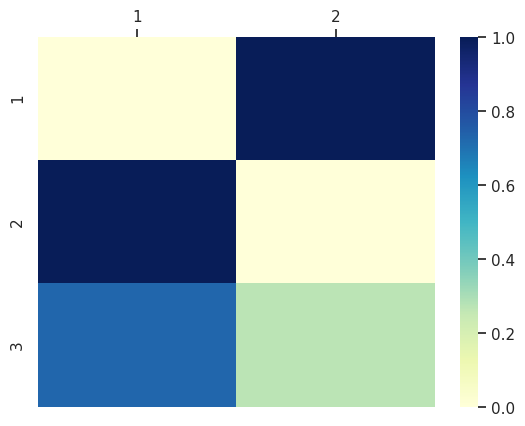

In [8]:
# HEAT MAPS
np.random.seed(0)
import seaborn as sns; sns.set_theme()
uniform_data = np.array([[0,1],
                        [1,0],
                        [0.73,0.27]])
ax = sns.heatmap(uniform_data,xticklabels=[1,2],yticklabels=[1,2,3],cmap="YlGnBu")
ax.xaxis.tick_top()
#plt.savefig('./graphs/kmpp_heatmap_kmeans_2_dim30.eps',dpi=300)
plt.show()

## Problem 7

In [84]:
# Problem 7

cluster_center = kmeans.cluster_centers_
inner_prod = np.inner(cluster_center,u_mat.T)
inner_prod_norm = np.zeros(inner_prod.shape)
for i in range(len(inner_prod)):
    inner_prod_norm[i,:] = (inner_prod[i,:] - np.mean(inner_prod,1)[i] )/np.std(inner_prod,1)[i]
#inner_prod_norm = (inner_prod - np.mean(inner_prod,1))/np.std(inner_prod,1)


In [85]:
inner_prod_norm.shape
#print(u_mat.shape)

(3, 6)

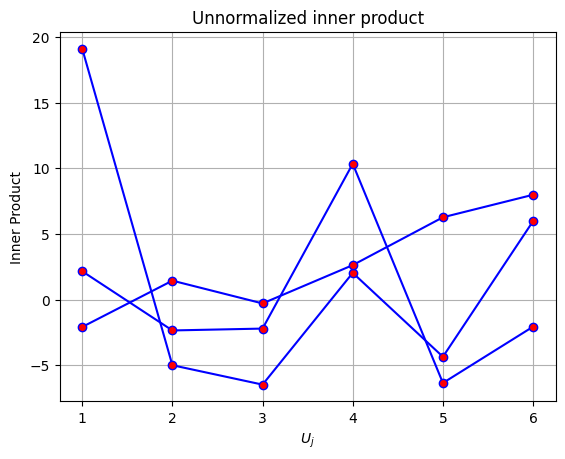

In [13]:
jtplot.reset()
from matplotlib import rc
for j in range(3):
    plt.plot(np.arange(1,7),inner_prod[j,:],'-', marker='o', markerfacecolor = 'r', color ='b')

plt.xlabel(r'$U_j$')
plt.ylabel('Inner Product')
plt.grid()
plt.title('Unnormalized inner product')
plt.show()

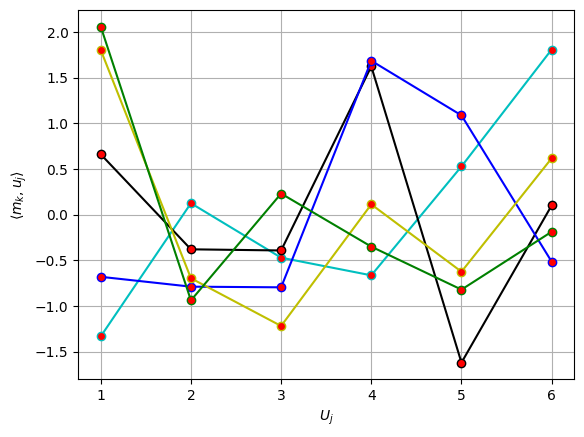

In [81]:
#for j in range(3):
plt.plot(np.arange(1,7),inner_prod_norm[0,:],'-', marker='o', markerfacecolor = 'r', color ='c')
plt.plot(np.arange(1,7),inner_prod_norm[1,:],'-', marker='o', markerfacecolor = 'r', color ='k')
plt.plot(np.arange(1,7),inner_prod_norm[2,:],'-', marker='o', markerfacecolor = 'r', color ='b')
plt.plot(np.arange(1,7),inner_prod_norm[3,:],'-', marker='o', markerfacecolor = 'r', color ='y')
plt.plot(np.arange(1,7),inner_prod_norm[4,:],'-', marker='o', markerfacecolor = 'r', color ='g')

plt.xlabel(r'$U_j$')
plt.ylabel(r'$\langle m_k,u_j \rangle$')
#plt.title('Normalized inner product')
plt.grid()
#plt.savefig('./graphs/norm_inner_product_5.eps',dpi=300)
plt.show()

#inner_prod_norm

## Problem 8

In [98]:
# Problem 8 
from sklearn.mixture import GaussianMixture
components = 2   # change from 2,3,4,5

gm = GaussianMixture(n_components = components, verbose=1, verbose_interval=20).fit(data)
cov_mat = gm.covariances_
eigen_val1, eigen_vec1 = np.linalg.eig(cov_mat[0,:,:])
eigen_val2, eigen_vec2 = np.linalg.eig(cov_mat[1,:,:])
#eigen_val3, eigen_vec3 = np.linalg.eig(cov_mat[2,:,:])
#eigen_val4, eigen_vec4 = np.linalg.eig(cov_mat[3,:,:])
#eigen_val5, eigen_vec5 = np.linalg.eig(cov_mat[4,:,:])

# How do the eigenvalues and eigenvectors relate to the parameters of the Gaussian mixture model ?

Initialization 0
Initialization converged: True


In [99]:
cov_mat.shape

(2, 30, 30)

In [27]:
eigen_vec1[0,:]

array([ 1.28353735e-07, -1.14477232e-06, -2.17624727e-01,  6.93711482e-02,
        1.36152862e-01,  6.76656007e-02,  6.77658988e-02, -6.88729535e-02,
       -1.49048584e-01,  1.97625280e-01,  2.18663665e-01,  9.06748883e-02,
        7.22813856e-02,  1.98366485e-01,  1.88506476e-01, -4.53520902e-01,
       -4.06894472e-01,  2.38517416e-01, -1.82100459e-01, -1.31549653e-01,
       -7.41939224e-02,  6.39965759e-02,  3.32839468e-02,  2.70652621e-01,
       -2.53619689e-01,  1.81515890e-01,  1.22097256e-01,  1.80244395e-01,
        1.00640728e-01,  2.45560177e-02])

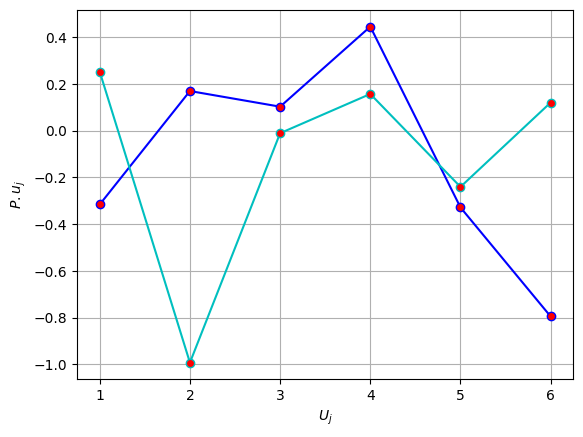

In [100]:
plt_values = np.zeros((6,1))

plt_values[0,0] = (np.inner(u_mat[:,0]/np.linalg.norm(u_mat[:,0]),eigen_vec1[:,1]/np.linalg.norm(eigen_vec1[:,1])))
plt_values[1,0] = (np.inner(u_mat[:,1]/np.linalg.norm(u_mat[:,1]),eigen_vec1[:,1]/np.linalg.norm(eigen_vec1[:,1])))
plt_values[2,0] = (np.inner(u_mat[:,2]/np.linalg.norm(u_mat[:,2]),eigen_vec1[:,1]/np.linalg.norm(eigen_vec1[:,1])))
plt_values[3,0] = (np.inner(u_mat[:,3]/np.linalg.norm(u_mat[:,3]),eigen_vec1[:,1]/np.linalg.norm(eigen_vec1[:,1])))
plt_values[4,0] = (np.inner(u_mat[:,4]/np.linalg.norm(u_mat[:,4]),eigen_vec1[:,1]/np.linalg.norm(eigen_vec1[:,1])))
plt_values[5,0] = (np.inner(u_mat[:,5]/np.linalg.norm(u_mat[:,5]),eigen_vec1[:,1]/np.linalg.norm(eigen_vec1[:,1])))

plt.plot(np.arange(1,7),plt_values,'-', marker='o', markerfacecolor = 'r', color ='b')

plt_values[0,0] = (np.inner(u_mat[:,0]/np.linalg.norm(u_mat[:,0]),eigen_vec2[:,1]/np.linalg.norm(eigen_vec2[:,1])))
plt_values[1,0] = (np.inner(u_mat[:,1]/np.linalg.norm(u_mat[:,1]),eigen_vec2[:,1]/np.linalg.norm(eigen_vec2[:,1])))
plt_values[2,0] = (np.inner(u_mat[:,2]/np.linalg.norm(u_mat[:,2]),eigen_vec2[:,1]/np.linalg.norm(eigen_vec2[:,1])))
plt_values[3,0] = (np.inner(u_mat[:,3]/np.linalg.norm(u_mat[:,3]),eigen_vec2[:,1]/np.linalg.norm(eigen_vec2[:,1])))
plt_values[4,0] = (np.inner(u_mat[:,4]/np.linalg.norm(u_mat[:,4]),eigen_vec2[:,1]/np.linalg.norm(eigen_vec2[:,1])))
plt_values[5,0] = (np.inner(u_mat[:,5]/np.linalg.norm(u_mat[:,5]),eigen_vec2[:,1]/np.linalg.norm(eigen_vec2[:,1])))


plt.plot(np.arange(1,7),plt_values,'-', marker='o', markerfacecolor = 'r', color ='c')


plt.xlabel(r'$U_j$')
plt.ylabel(r'$P. u_j$')
plt.grid()
plt.savefig('./graphs/eigen_vector_K_2.eps',dpi=300)
plt.show()